In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start=0, end=None):
  plt.plot(time[start:end], series[start:end], "-")
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(False)

def trend(time, slope=0):
  return slope * time

def seasonal_pattern(season_time):
  return np.where(season_time < 0.1,
                  np.cos(season_time * 6 * np.pi),
                  2 / np.exp(6 * season_time))

def seasonality(time, period, amplitude=1):
  season_time = (time % period) / period
  return amplitude * seasonal_pattern(season_time)

def noise(time, noise=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise

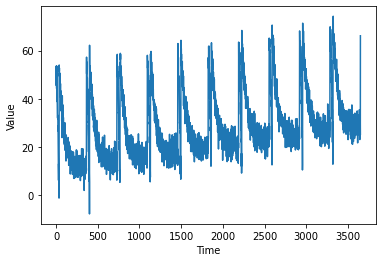

In [3]:
time = np.arange(10 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.005
noise_level = 3

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=51)

split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

plot_series(time, series)

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda window: window.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  ds = ds.batch(batch_size).prefetch(1)
  return ds

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(32)
np.random.seed(32)

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*10.0)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(dataset, epochs=200)

Epoch 1/200
94/94 [==============================] - 2s 17ms/step - loss: 15.2472 - mae: 15.7418
Epoch 2/200
94/94 [==============================] - 2s 16ms/step - loss: 9.2298 - mae: 9.7114
Epoch 3/200
94/94 [==============================] - 2s 17ms/step - loss: 8.7941 - mae: 9.2788
Epoch 4/200
94/94 [==============================] - 2s 16ms/step - loss: 8.4015 - mae: 8.8851
Epoch 5/200
94/94 [==============================] - 2s 17ms/step - loss: 7.7052 - mae: 8.1870
Epoch 6/200
94/94 [==============================] - 2s 17ms/step - loss: 6.8989 - mae: 7.3776
Epoch 7/200
94/94 [==============================] - 2s 16ms/step - loss: 6.2521 - mae: 6.7280
Epoch 8/200
94/94 [==============================] - 2s 17ms/step - loss: 5.7581 - mae: 6.2287
Epoch 9/200
94/94 [==============================] - 2s 16ms/step - loss: 5.3808 - mae: 5.8508
Epoch 10/200
94/94 [==============================] - 2s 17ms/step - loss: 5.1929 - mae: 5.6626
Epoch 11/200
94/94 [===========================

3.1785932


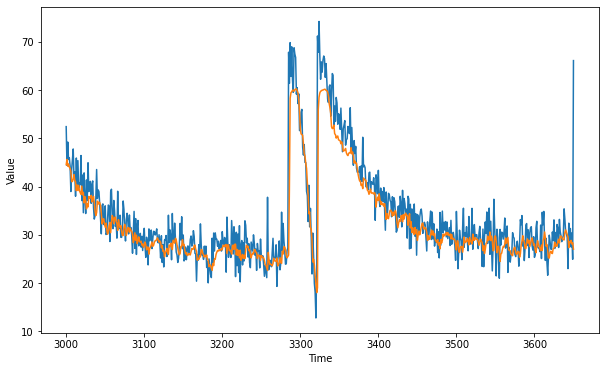

In [6]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

<Figure size 432x288 with 0 Axes>

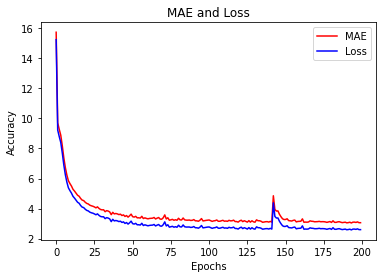

<Figure size 432x288 with 0 Axes>

In [7]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()